# Working with CO Aggregated Data

Pre-processing input data for a smoother upload experience of the state data to the WaDE 2.0 database.
Using geopandas to read in shp file, and coverting to WKT for ReportingUnit geometry.

Separating tasks out into two processes. 
- 1) create aggregate amount time series input.
- 2) create reporting unit input.

In [10]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Working Directory
workingDir = "G:/Shared drives/WaDE Data/Colorado/AggregatedAmounts"
os.chdir(workingDir)

## Timeseries Data

In [3]:
# Input file
fileInput = "RawInputData/DWR__Surface_Water_Supply_Index_Component_by_HUC_input.xlsx"
df = pd.read_excel(fileInput)
df.head(1)

,Basin,HUC8,HUC8 Name,Report Year,Report Month,in_TimeframeStart,in_TimeframeEnd,Component Type,Component ID,Component Name,Component Volume,Component NEP
0,Arkansas,11020001,Arkansas Headwaters,2010,10,10/01/2010,2010-10-31,ReservoirStorage,7007020,CLEAR CREEK RESERVOIR,6500.0,61.19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18661 entries, 0 to 18660
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Basin              18661 non-null  object        
 1   HUC8               18661 non-null  int64         
 2   HUC8 Name          18661 non-null  object        
 3   Report Year        18661 non-null  int64         
 4   Report Month       18661 non-null  int64         
 5   in_TimeframeStart  18661 non-null  object        
 6   in_TimeframeEnd    18661 non-null  datetime64[ns]
 7   Component Type     18661 non-null  object        
 8   Component ID       18661 non-null  object        
 9   Component Name     18661 non-null  object        
 10  Component Volume   18661 non-null  float64       
 11  Component NEP      18661 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 1.7+ MB


In [5]:
#Changing datatype of used date fields. 
df['in_TimeframeStart'] = pd.to_datetime(df['in_TimeframeStart'], errors = 'coerce')
df['in_TimeframeStart'] = pd.to_datetime(df["in_TimeframeStart"].dt.strftime('%m/%d/%Y'))
df['in_TimeframeEnd'] = pd.to_datetime(df['in_TimeframeEnd'], errors = 'coerce')
df['in_TimeframeEnd'] = pd.to_datetime(df["in_TimeframeEnd"].dt.strftime('%m/%d/%Y'))
df.head(1)

,Basin,HUC8,HUC8 Name,Report Year,Report Month,in_TimeframeStart,in_TimeframeEnd,Component Type,Component ID,Component Name,Component Volume,Component NEP
0,Arkansas,11020001,Arkansas Headwaters,2010,10,2010-10-01,2010-10-31,ReservoirStorage,7007020,CLEAR CREEK RESERVOIR,6500.0,61.19


In [6]:
# VariableSpecificCV
df['in_VariableSpecificCV'] = df['Component Type'].astype(str) + "_Monthly_Unspecified_Surface Water"
df['in_VariableSpecificCV'].unique()

array(['ReservoirStorage_Monthly_Unspecified_Surface Water',
       'ForecastedRunoff_Monthly_Unspecified_Surface Water',
       'PrevMoStreamflow_Monthly_Unspecified_Surface Water'], dtype=object)

## Shapefile Data

In [7]:
#Shapefile input
shapeInput = gpd.read_file('RawInputData/HUC8/CO_HUC8.shp')
dfshapetemp = pd.DataFrame(shapeInput)
dfshapetemp.head(1)

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC8,NAME,Shape_Leng,Shape_Le_1,Shape_Le_2,Shape_Area,geometry
0,{4CCAA733-584D-4347-A7F3-4E664ADA8B9B},None,None,None,None,2012-06-11,0,1104144.63,4468.32,"CO,NM",11080001,Canadian Headwaters,3.943636,3.943636,3.943636,0.450856,"POLYGON ((-104.18034 36.92065, -104.18082 36.9..."


In [8]:
#check shp input Water Plan Area
dfshape = pd.DataFrame()

columnsList = ['RU_ID', 'geometry']
dfshape = pd.DataFrame(columns=columnsList)
dfshape['RU_ID'] = dfshapetemp['HUC8']
dfshape['geometry'] = dfshapetemp['geometry']
dfshape = dfshape.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
dfshape.head(3)

,RU_ID,geometry
0,11080001,"POLYGON ((-104.18034 36.92065, -104.18082 36.9..."
1,13020101,"POLYGON ((-105.23391 37.03586, -105.23421 37.0..."
2,13020102,"POLYGON ((-106.58821 37.13834, -106.58788 37.1..."


<AxesSubplot:>

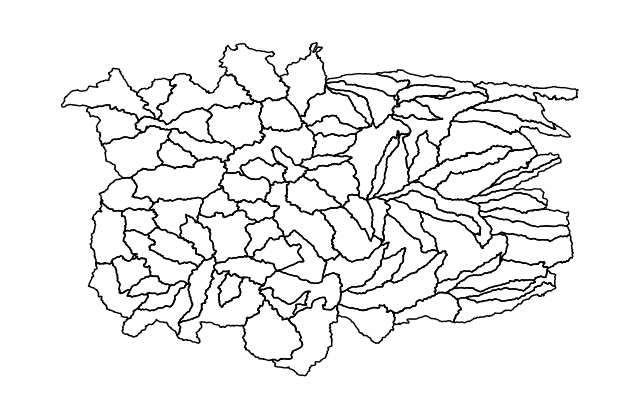

In [13]:
dfshape = gpd.GeoDataFrame(dfshape, geometry=dfshape['geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(dfshape)

## Export

In [14]:
df.to_csv('RawInputData/P_coAggMaster.csv', index=False) # The master Output - csv file
dfshape.to_csv('RawInputData/P_coGeometry.csv', index=False) # the shapefile output - csv file